In [1]:
import time
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

In [3]:
import numpy  as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
transform = transforms.ToTensor()

In [5]:
train_data = datasets.MNIST(root='./Data', train= True, download= True, transform=transform)

In [6]:
test_data = datasets.MNIST(root='./Data', train= False, download=True, transform = transform)

In [7]:
train_data,test_data

(Dataset MNIST
     Number of datapoints: 60000
     Split: train
     Root Location: ./Data
     Transforms (if any): ToTensor()
     Target Transforms (if any): None,
 Dataset MNIST
     Number of datapoints: 10000
     Split: test
     Root Location: ./Data
     Transforms (if any): ToTensor()
     Target Transforms (if any): None)

In [8]:
train_loader = DataLoader(train_data, batch_size=10,shuffle=True)

In [9]:
test_loader = DataLoader(test_data, batch_size=10,shuffle=False)

In [10]:
#1 input channel is for grey image
#6 filters(o/p channels) for feature extraction(arbitary number)
#3 is kernel size, 3*3 filter
#1 is stride
conv1 = nn.Conv2d(1,6,3,1) # ---> 6 filters --> pooling layer --> conv2

#6 input filters from conv1, 16 filters(arbitary number)
conv2 = nn.Conv2d(6,16,3,1)

In [11]:
conv1,conv2

(Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1)),
 Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1)))

In [12]:
for i,(X_train,y_train) in enumerate(train_data):
    break

In [13]:
X_train.shape #---> convert to 4D batch(batch of 1 image)

torch.Size([1, 28, 28])

In [14]:
x = X_train.view(1,1,28,28)

In [15]:
x.shape

torch.Size([1, 1, 28, 28])

In [16]:
x = F.relu(conv1(x))

In [17]:
x.shape #26*26 o/p 'cos while doing covolution we lost border info. One way to achieve is by adding padding=1 in nn.Conv2d fn

torch.Size([1, 6, 26, 26])

In [18]:
x = F.max_pool2d(x,2,2)

In [19]:
x.shape #13*13 'cos filter size is 2*2

torch.Size([1, 6, 13, 13])

In [20]:
x = F.relu(conv2(x))

In [21]:
x.shape

torch.Size([1, 16, 11, 11])

In [22]:
x = F.max_pool2d(x,2,2)

In [23]:
x.shape

torch.Size([1, 16, 5, 5])

In [24]:
#lets feed this to fully connected flat layer. For this we have to flat x to 1,16*5*5
x.view(-1,16*5*5).shape

torch.Size([1, 400])

In [25]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84,10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 5*5*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [26]:
torch.manual_seed(42)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [27]:
for param in model.parameters():
    print(param.numel())

54
6
864
16
48000
120
10080
84
840
10


In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [44]:
import time
start_time = time.time()

epochs = 1
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        # Apply the model
        y_pred = model(X_train)  # we don't flatten X-train here
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%600 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/60000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
        
    train_losses.append(loss)
    train_correct.append(trn_corr)
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed            

tensor([1, 4, 8, 5, 6, 0, 9, 2, 4, 5])
tensor([6, 6, 3, 1, 5, 6, 5, 2, 4, 4])
tensor([6, 5, 5, 8, 0, 3, 6, 1, 9, 6])
tensor([8, 8, 7, 8, 0, 3, 3, 6, 0, 3])
tensor([0, 9, 1, 7, 0, 3, 9, 8, 7, 0])
tensor([5, 0, 4, 3, 8, 2, 6, 1, 8, 2])
tensor([6, 3, 9, 9, 4, 8, 9, 7, 9, 7])
tensor([9, 7, 2, 8, 1, 1, 5, 0, 1, 9])
tensor([6, 3, 0, 9, 2, 0, 7, 3, 7, 6])
tensor([3, 3, 4, 6, 9, 9, 2, 6, 0, 3])
tensor([6, 2, 8, 6, 8, 7, 3, 3, 7, 2])
tensor([8, 7, 3, 7, 3, 0, 9, 2, 6, 2])
tensor([6, 4, 3, 4, 8, 3, 4, 3, 6, 3])
tensor([2, 5, 1, 7, 5, 6, 0, 9, 6, 3])
tensor([5, 3, 8, 4, 4, 2, 1, 3, 9, 1])
tensor([9, 6, 6, 4, 2, 7, 8, 2, 3, 6])
tensor([2, 1, 7, 4, 1, 6, 1, 6, 8, 1])
tensor([5, 5, 1, 2, 5, 4, 1, 1, 9, 5])
tensor([1, 8, 6, 0, 0, 5, 8, 7, 7, 5])
tensor([4, 2, 2, 5, 6, 0, 2, 5, 2, 7])
tensor([8, 1, 0, 8, 1, 2, 7, 9, 8, 4])
tensor([0, 1, 8, 7, 6, 0, 0, 7, 4, 7])
tensor([8, 3, 9, 2, 5, 1, 8, 6, 3, 7])
tensor([0, 1, 5, 7, 4, 4, 1, 9, 8, 2])
tensor([8, 9, 6, 5, 5, 6, 4, 4, 8, 0])
tensor([8, 9, 7, 2, 3, 3,

tensor([1, 2, 9, 7, 9, 4, 4, 9, 8, 9])
tensor([6, 0, 8, 6, 6, 6, 4, 5, 9, 7])
tensor([5, 1, 6, 6, 9, 4, 2, 4, 9, 4])
tensor([6, 2, 2, 2, 7, 5, 1, 1, 8, 7])
tensor([2, 6, 7, 1, 5, 1, 7, 5, 7, 3])
tensor([1, 4, 7, 2, 1, 9, 5, 6, 5, 5])
tensor([3, 3, 2, 7, 3, 1, 5, 1, 1, 4])
tensor([1, 1, 3, 4, 7, 9, 8, 4, 8, 9])
tensor([7, 0, 6, 8, 6, 4, 3, 7, 9, 3])
tensor([2, 3, 6, 0, 4, 5, 7, 7, 8, 5])
tensor([8, 8, 4, 9, 2, 6, 5, 6, 3, 3])
tensor([2, 3, 7, 1, 2, 2, 3, 6, 9, 7])
tensor([9, 7, 8, 6, 9, 6, 5, 5, 7, 8])
tensor([4, 1, 5, 0, 1, 8, 5, 9, 7, 6])
tensor([2, 8, 7, 4, 8, 5, 4, 4, 3, 4])
tensor([6, 0, 2, 7, 4, 7, 9, 9, 4, 0])
tensor([9, 5, 0, 5, 4, 5, 5, 1, 3, 1])
tensor([0, 5, 7, 7, 8, 0, 0, 8, 4, 8])
tensor([5, 8, 5, 7, 3, 5, 1, 2, 2, 0])
tensor([0, 4, 5, 9, 4, 0, 1, 3, 6, 7])
tensor([0, 0, 3, 0, 3, 3, 9, 6, 0, 4])
tensor([7, 9, 4, 1, 9, 7, 6, 1, 0, 6])
tensor([6, 5, 3, 1, 8, 7, 3, 8, 4, 2])
tensor([6, 2, 8, 0, 6, 3, 5, 5, 2, 4])
tensor([9, 4, 2, 7, 9, 0, 1, 5, 3, 0])
tensor([7, 3, 8, 0, 9, 6,

tensor([8, 2, 8, 0, 4, 5, 3, 5, 5, 1])
tensor([1, 1, 2, 4, 0, 1, 6, 1, 0, 9])
tensor([1, 9, 2, 5, 6, 1, 9, 6, 2, 0])
tensor([1, 1, 3, 7, 2, 1, 6, 7, 8, 7])
tensor([0, 1, 8, 6, 6, 4, 9, 7, 2, 1])
tensor([5, 8, 2, 5, 6, 6, 4, 8, 4, 3])
tensor([3, 9, 8, 6, 1, 1, 2, 1, 6, 3])
tensor([6, 5, 8, 9, 7, 1, 2, 1, 5, 7])
tensor([2, 5, 8, 3, 9, 1, 4, 7, 5, 5])
tensor([7, 7, 3, 5, 6, 1, 9, 0, 8, 1])
tensor([4, 6, 6, 8, 8, 3, 9, 1, 3, 8])
tensor([3, 8, 1, 2, 6, 7, 5, 8, 6, 9])
tensor([3, 3, 6, 2, 8, 3, 9, 8, 7, 3])
tensor([2, 1, 1, 7, 2, 9, 5, 3, 9, 6])
tensor([4, 4, 0, 0, 7, 7, 9, 8, 2, 0])
tensor([8, 0, 3, 7, 1, 6, 7, 7, 5, 0])
tensor([0, 6, 7, 2, 5, 1, 9, 3, 9, 0])
tensor([4, 4, 7, 2, 6, 0, 1, 9, 7, 7])
tensor([7, 9, 7, 9, 5, 7, 5, 0, 1, 0])
tensor([5, 0, 1, 1, 9, 0, 2, 4, 4, 8])
tensor([2, 5, 5, 6, 2, 8, 2, 6, 4, 8])
tensor([4, 7, 3, 9, 5, 3, 2, 9, 4, 2])
tensor([6, 6, 9, 7, 3, 1, 8, 5, 9, 7])
tensor([5, 5, 8, 8, 7, 3, 3, 1, 7, 8])
tensor([9, 6, 1, 7, 1, 2, 9, 4, 5, 1])
tensor([0, 1, 5, 2, 4, 9,

tensor([8, 5, 0, 4, 5, 8, 7, 3, 0, 7])
tensor([3, 2, 6, 1, 2, 4, 7, 9, 4, 6])
tensor([8, 6, 0, 3, 7, 3, 3, 0, 5, 1])
tensor([5, 4, 1, 2, 3, 4, 7, 6, 8, 1])
tensor([9, 6, 8, 6, 6, 9, 1, 5, 1, 5])
tensor([8, 1, 0, 3, 9, 5, 6, 2, 4, 8])
tensor([6, 6, 0, 3, 9, 0, 1, 7, 6, 5])
tensor([4, 9, 4, 8, 2, 4, 5, 1, 9, 6])
tensor([5, 7, 9, 4, 5, 5, 6, 2, 2, 1])
tensor([9, 6, 1, 6, 1, 8, 4, 7, 5, 9])
tensor([6, 2, 9, 1, 6, 1, 8, 5, 6, 4])
tensor([4, 9, 6, 3, 4, 6, 2, 1, 0, 3])
tensor([4, 8, 4, 3, 0, 5, 1, 0, 2, 3])
tensor([4, 8, 5, 3, 0, 8, 3, 1, 7, 4])
tensor([5, 7, 6, 2, 4, 8, 9, 0, 1, 3])
tensor([8, 4, 6, 4, 6, 8, 4, 2, 0, 0])
tensor([7, 7, 8, 3, 3, 8, 2, 4, 4, 6])
tensor([6, 4, 4, 4, 7, 6, 0, 9, 0, 9])
tensor([6, 7, 7, 2, 2, 2, 3, 8, 6, 8])
tensor([5, 6, 1, 9, 4, 7, 0, 7, 8, 4])
tensor([3, 6, 0, 1, 6, 8, 3, 4, 9, 6])
tensor([2, 9, 3, 9, 1, 8, 9, 7, 1, 6])
tensor([9, 5, 0, 8, 9, 3, 5, 3, 3, 8])
tensor([6, 8, 2, 5, 2, 4, 2, 1, 1, 7])
tensor([3, 2, 9, 6, 7, 5, 8, 1, 6, 4])
tensor([2, 2, 5, 3, 6, 5,

tensor([0, 3, 4, 1, 4, 3, 8, 9, 9, 4])
tensor([3, 3, 4, 1, 6, 0, 1, 2, 0, 0])
tensor([6, 5, 6, 4, 1, 6, 4, 5, 3, 3])
tensor([2, 9, 0, 5, 8, 8, 3, 0, 7, 1])
tensor([1, 3, 1, 0, 6, 4, 8, 8, 0, 8])
tensor([2, 9, 1, 1, 1, 8, 6, 3, 1, 1])
tensor([7, 9, 9, 4, 7, 7, 1, 5, 0, 7])
tensor([9, 1, 1, 8, 6, 8, 7, 0, 7, 4])
tensor([0, 0, 5, 9, 0, 0, 6, 8, 6, 2])
tensor([4, 5, 4, 3, 5, 9, 7, 5, 5, 9])
tensor([5, 3, 9, 0, 6, 3, 1, 3, 5, 5])
tensor([6, 5, 0, 8, 8, 9, 2, 1, 0, 8])
tensor([4, 7, 8, 0, 1, 9, 0, 7, 4, 9])
tensor([0, 3, 2, 1, 6, 9, 9, 5, 2, 0])
tensor([8, 8, 6, 8, 0, 9, 6, 3, 4, 3])
tensor([1, 1, 0, 1, 2, 7, 0, 5, 1, 7])
tensor([2, 1, 4, 8, 7, 9, 3, 3, 1, 4])
tensor([3, 2, 0, 7, 3, 7, 5, 6, 6, 0])
tensor([6, 0, 9, 7, 6, 1, 8, 9, 4, 0])
tensor([7, 5, 7, 3, 4, 4, 7, 2, 3, 7])
tensor([4, 8, 9, 2, 8, 2, 5, 1, 9, 1])
tensor([5, 6, 3, 3, 3, 7, 5, 8, 2, 3])
tensor([9, 6, 3, 0, 5, 6, 1, 5, 3, 0])
tensor([7, 2, 6, 5, 2, 9, 0, 1, 9, 1])
tensor([7, 6, 2, 4, 1, 8, 7, 0, 6, 4])
tensor([3, 9, 3, 0, 3, 2,

tensor([3, 4, 7, 2, 8, 3, 1, 5, 8, 2])
tensor([4, 1, 6, 6, 5, 7, 9, 7, 0, 4])
tensor([7, 1, 3, 5, 3, 7, 1, 7, 6, 3])
tensor([7, 1, 7, 7, 4, 7, 4, 4, 4, 1])
tensor([2, 8, 8, 1, 0, 0, 9, 7, 0, 8])
tensor([3, 7, 6, 3, 6, 4, 3, 2, 5, 9])
tensor([9, 9, 8, 6, 0, 2, 4, 4, 5, 0])
tensor([7, 0, 3, 1, 1, 3, 5, 6, 9, 9])
tensor([6, 9, 4, 6, 9, 9, 9, 6, 0, 8])
tensor([0, 7, 9, 0, 6, 1, 0, 5, 0, 9])
tensor([4, 0, 4, 7, 9, 5, 1, 0, 7, 9])
tensor([7, 6, 7, 3, 8, 4, 1, 3, 9, 0])
tensor([6, 5, 2, 5, 8, 2, 3, 9, 8, 0])
tensor([3, 6, 7, 3, 6, 8, 1, 2, 3, 6])
tensor([1, 7, 5, 7, 3, 7, 9, 7, 6, 2])
tensor([6, 6, 5, 2, 8, 8, 4, 2, 1, 0])
tensor([1, 4, 1, 7, 7, 4, 0, 9, 4, 3])
tensor([8, 2, 3, 5, 1, 6, 3, 8, 5, 0])
tensor([3, 3, 0, 8, 4, 7, 1, 8, 9, 8])
tensor([8, 6, 1, 6, 0, 2, 3, 9, 1, 5])
tensor([7, 5, 4, 2, 1, 4, 2, 3, 7, 9])
tensor([1, 1, 4, 0, 3, 9, 4, 5, 0, 7])
tensor([6, 7, 9, 4, 3, 3, 5, 2, 7, 0])
tensor([8, 2, 6, 8, 9, 2, 9, 7, 3, 8])
tensor([5, 3, 6, 5, 6, 9, 8, 5, 7, 2])
tensor([5, 3, 7, 6, 3, 2,

tensor([4, 7, 4, 1, 8, 2, 1, 1, 5, 7])
tensor([1, 8, 6, 4, 9, 3, 5, 2, 3, 5])
tensor([2, 6, 3, 2, 9, 3, 8, 9, 8, 2])
tensor([0, 5, 6, 0, 9, 3, 2, 5, 4, 0])
tensor([2, 9, 8, 7, 1, 0, 0, 7, 6, 0])
tensor([6, 9, 7, 7, 4, 6, 8, 3, 7, 5])
tensor([5, 9, 6, 5, 8, 4, 2, 7, 1, 2])
tensor([3, 6, 5, 6, 9, 0, 0, 8, 6, 0])
tensor([0, 0, 4, 4, 6, 2, 6, 4, 1, 1])
tensor([9, 4, 5, 5, 0, 3, 8, 1, 2, 9])
tensor([0, 0, 2, 6, 9, 4, 3, 9, 1, 0])
tensor([6, 7, 7, 3, 2, 7, 8, 4, 0, 2])
tensor([4, 7, 4, 1, 3, 1, 8, 2, 5, 8])
tensor([8, 9, 7, 4, 1, 1, 6, 4, 2, 5])
tensor([4, 1, 2, 1, 1, 1, 5, 5, 4, 1])
tensor([2, 4, 1, 8, 4, 5, 1, 7, 1, 9])
tensor([3, 5, 0, 9, 3, 7, 8, 2, 5, 7])
tensor([0, 6, 1, 0, 8, 8, 6, 1, 2, 8])
tensor([7, 1, 0, 0, 7, 1, 2, 8, 8, 4])
tensor([4, 7, 6, 0, 9, 3, 2, 7, 2, 6])
tensor([3, 4, 2, 7, 7, 0, 4, 6, 4, 1])
tensor([6, 5, 9, 3, 8, 0, 4, 6, 4, 6])
tensor([0, 8, 6, 2, 5, 1, 4, 0, 7, 1])
tensor([3, 9, 5, 5, 4, 7, 0, 4, 6, 6])
tensor([4, 6, 4, 9, 0, 2, 3, 7, 0, 7])
tensor([5, 8, 1, 5, 9, 9,

tensor([3, 0, 7, 0, 7, 0, 6, 7, 6, 3])
tensor([8, 5, 5, 2, 6, 6, 9, 1, 4, 8])
tensor([5, 2, 4, 7, 7, 0, 4, 4, 3, 6])
tensor([5, 3, 9, 0, 0, 8, 2, 7, 0, 2])
tensor([6, 0, 9, 1, 3, 3, 4, 1, 3, 2])
tensor([4, 9, 5, 6, 2, 1, 5, 1, 8, 1])
tensor([9, 1, 6, 7, 0, 8, 3, 3, 6, 4])
tensor([8, 1, 9, 5, 3, 9, 2, 0, 2, 0])
tensor([1, 3, 5, 1, 7, 5, 2, 1, 7, 9])
tensor([8, 9, 6, 6, 7, 1, 3, 4, 9, 2])
tensor([4, 3, 2, 7, 4, 1, 1, 9, 3, 0])
tensor([9, 0, 7, 5, 2, 2, 2, 0, 7, 7])
tensor([7, 0, 8, 8, 8, 8, 1, 0, 6, 8])
tensor([3, 0, 7, 4, 0, 4, 2, 9, 5, 6])
tensor([6, 2, 3, 2, 1, 0, 2, 3, 2, 1])
tensor([5, 3, 4, 0, 7, 3, 0, 6, 0, 5])
tensor([8, 0, 3, 3, 4, 1, 3, 0, 3, 2])
tensor([9, 7, 0, 1, 3, 5, 0, 5, 4, 5])
tensor([3, 4, 6, 3, 6, 7, 3, 3, 8, 1])
tensor([7, 5, 1, 2, 3, 6, 5, 7, 2, 7])
tensor([1, 1, 0, 2, 5, 0, 3, 3, 5, 5])
tensor([5, 3, 1, 9, 4, 4, 9, 4, 4, 9])
tensor([8, 6, 6, 4, 2, 3, 6, 4, 6, 8])
tensor([1, 9, 9, 2, 7, 3, 9, 8, 9, 0])
tensor([7, 6, 4, 1, 8, 9, 5, 7, 0, 3])
tensor([2, 9, 0, 6, 5, 1,

tensor([5, 1, 2, 3, 8, 1, 1, 0, 7, 7])
tensor([8, 3, 6, 6, 3, 1, 6, 4, 0, 7])
tensor([8, 2, 7, 7, 9, 7, 1, 0, 8, 5])
tensor([1, 2, 6, 3, 8, 3, 1, 4, 5, 8])
tensor([8, 2, 1, 8, 0, 3, 6, 0, 3, 1])
tensor([1, 8, 5, 7, 1, 6, 1, 2, 3, 1])
tensor([5, 2, 5, 8, 0, 4, 8, 8, 5, 7])
tensor([6, 5, 0, 5, 1, 2, 5, 7, 3, 3])
tensor([7, 7, 0, 3, 2, 2, 2, 5, 2, 9])
tensor([3, 4, 2, 9, 5, 2, 2, 3, 1, 9])
tensor([3, 5, 6, 6, 5, 0, 0, 2, 7, 8])
tensor([3, 2, 0, 6, 4, 9, 5, 5, 7, 8])
tensor([6, 3, 8, 9, 0, 5, 4, 2, 1, 8])
tensor([8, 7, 8, 1, 6, 4, 0, 9, 2, 7])
tensor([0, 9, 5, 7, 0, 3, 4, 4, 7, 8])
tensor([1, 7, 1, 8, 0, 7, 6, 1, 0, 9])
tensor([9, 5, 9, 3, 2, 3, 4, 2, 4, 5])
tensor([9, 9, 1, 5, 2, 6, 0, 9, 7, 1])
tensor([1, 7, 2, 8, 1, 7, 5, 5, 9, 6])
tensor([1, 1, 2, 9, 9, 5, 8, 6, 3, 0])
tensor([6, 8, 7, 8, 4, 4, 5, 3, 5, 7])
tensor([2, 5, 7, 9, 2, 9, 3, 8, 5, 2])
tensor([3, 3, 0, 5, 9, 9, 0, 7, 3, 0])
tensor([0, 2, 9, 0, 3, 4, 2, 4, 7, 7])
tensor([2, 0, 1, 6, 0, 2, 3, 6, 5, 7])
tensor([3, 1, 9, 8, 5, 9,

tensor([1, 3, 7, 3, 1, 8, 5, 7, 8, 4])
tensor([9, 8, 3, 9, 1, 6, 6, 1, 5, 8])
tensor([6, 2, 3, 7, 7, 7, 1, 4, 6, 4])
tensor([6, 3, 5, 7, 8, 5, 6, 1, 0, 1])
tensor([7, 2, 6, 1, 9, 8, 0, 6, 0, 6])
tensor([9, 3, 7, 5, 7, 6, 7, 2, 7, 8])
tensor([4, 7, 5, 1, 9, 5, 1, 0, 4, 6])
tensor([7, 8, 9, 1, 7, 2, 0, 1, 9, 3])
tensor([5, 3, 0, 9, 8, 2, 7, 4, 6, 8])
tensor([8, 7, 8, 0, 8, 9, 2, 8, 7, 2])
tensor([3, 9, 0, 3, 5, 8, 0, 5, 7, 6])
tensor([1, 8, 3, 7, 6, 7, 9, 7, 6, 3])
tensor([6, 1, 6, 5, 9, 1, 4, 9, 4, 1])
tensor([7, 8, 4, 9, 5, 2, 0, 6, 6, 3])
tensor([1, 1, 6, 1, 3, 0, 1, 8, 2, 0])
tensor([3, 5, 5, 3, 2, 6, 8, 4, 7, 3])
tensor([9, 0, 1, 1, 2, 4, 1, 8, 3, 0])
tensor([7, 7, 7, 5, 6, 2, 6, 4, 9, 0])
tensor([0, 7, 2, 2, 9, 1, 4, 9, 9, 2])
tensor([1, 7, 5, 3, 0, 8, 1, 1, 2, 3])
tensor([4, 9, 6, 3, 5, 4, 6, 2, 2, 2])
tensor([0, 9, 7, 6, 0, 0, 0, 1, 5, 8])
tensor([0, 7, 6, 6, 3, 6, 4, 0, 0, 0])
tensor([7, 8, 3, 8, 2, 5, 3, 8, 8, 5])
tensor([7, 7, 6, 3, 5, 8, 3, 0, 1, 7])
tensor([2, 7, 9, 7, 9, 2,

tensor([5, 1, 9, 4, 8, 6, 9, 7, 1, 5])
tensor([5, 4, 5, 0, 7, 1, 7, 1, 6, 6])
tensor([4, 1, 2, 6, 5, 7, 1, 8, 2, 6])
tensor([9, 3, 8, 0, 9, 7, 4, 2, 8, 8])
tensor([3, 3, 1, 6, 2, 2, 1, 5, 8, 7])
tensor([7, 6, 2, 1, 0, 1, 7, 0, 8, 0])
tensor([0, 5, 7, 9, 2, 5, 1, 6, 8, 5])
tensor([6, 9, 4, 8, 8, 3, 2, 2, 7, 4])
tensor([4, 1, 4, 4, 3, 7, 9, 2, 3, 2])
tensor([3, 2, 4, 4, 3, 1, 1, 5, 8, 1])
tensor([5, 0, 5, 1, 9, 8, 5, 8, 5, 5])
tensor([2, 0, 0, 5, 8, 0, 7, 6, 9, 4])
tensor([3, 0, 7, 4, 5, 6, 0, 9, 7, 9])
tensor([8, 1, 4, 4, 8, 4, 5, 5, 3, 6])
tensor([1, 7, 4, 6, 3, 5, 9, 5, 9, 7])
tensor([5, 3, 3, 7, 6, 4, 4, 0, 4, 9])
tensor([0, 6, 8, 7, 6, 6, 1, 8, 6, 2])
tensor([9, 9, 1, 4, 8, 8, 0, 3, 0, 9])
tensor([0, 4, 6, 9, 4, 1, 7, 1, 2, 6])
tensor([8, 2, 5, 5, 2, 3, 9, 5, 4, 3])
tensor([3, 9, 9, 4, 6, 2, 2, 7, 1, 4])
tensor([8, 0, 4, 8, 8, 0, 7, 2, 8, 5])
tensor([0, 0, 2, 9, 1, 9, 1, 6, 1, 4])
epoch:  0  batch: 2400 [ 24000/60000]  loss: 0.00023113  accuracy:  98.504%
tensor([3, 8, 9, 7, 7, 2, 8

tensor([8, 8, 0, 1, 4, 1, 1, 1, 1, 0])
tensor([9, 9, 1, 9, 2, 7, 1, 5, 9, 8])
tensor([6, 5, 7, 8, 8, 3, 6, 5, 8, 6])
tensor([9, 6, 4, 8, 8, 0, 2, 1, 9, 9])
tensor([7, 9, 0, 0, 2, 8, 9, 1, 9, 1])
tensor([8, 8, 8, 8, 1, 4, 6, 0, 7, 6])
tensor([8, 1, 4, 1, 7, 8, 5, 6, 3, 3])
tensor([6, 1, 7, 8, 8, 7, 3, 1, 0, 3])
tensor([9, 8, 4, 9, 9, 0, 2, 4, 3, 6])
tensor([6, 0, 1, 0, 3, 3, 7, 9, 9, 6])
tensor([9, 0, 9, 4, 2, 7, 3, 1, 4, 3])
tensor([1, 4, 8, 4, 8, 8, 4, 0, 8, 0])
tensor([4, 5, 6, 3, 4, 2, 3, 5, 3, 3])
tensor([9, 9, 4, 3, 1, 2, 1, 5, 1, 9])
tensor([9, 4, 0, 1, 0, 7, 2, 1, 5, 0])
tensor([8, 8, 6, 4, 9, 7, 5, 6, 2, 4])
tensor([6, 8, 7, 0, 9, 9, 9, 2, 3, 9])
tensor([1, 4, 7, 2, 4, 2, 9, 5, 3, 6])
tensor([9, 6, 0, 5, 3, 5, 8, 1, 4, 9])
tensor([0, 3, 1, 9, 1, 9, 8, 7, 4, 7])
tensor([9, 0, 9, 6, 7, 9, 3, 2, 1, 0])
tensor([1, 4, 1, 4, 7, 1, 4, 4, 9, 4])
tensor([0, 8, 4, 0, 1, 7, 0, 2, 4, 9])
tensor([5, 3, 7, 2, 8, 8, 0, 4, 5, 4])
tensor([7, 4, 6, 1, 7, 1, 5, 2, 2, 5])
tensor([0, 9, 0, 1, 5, 4,

tensor([0, 5, 5, 8, 9, 6, 0, 6, 4, 0])
tensor([7, 6, 5, 0, 9, 5, 7, 0, 3, 6])
tensor([0, 3, 8, 5, 4, 5, 1, 2, 0, 7])
tensor([5, 3, 1, 0, 1, 0, 7, 6, 1, 0])
tensor([4, 1, 7, 7, 1, 9, 8, 3, 6, 0])
tensor([4, 0, 8, 5, 3, 9, 4, 0, 1, 0])
tensor([4, 5, 1, 3, 8, 1, 6, 0, 3, 3])
tensor([4, 8, 1, 0, 1, 7, 8, 3, 2, 0])
tensor([7, 6, 1, 1, 4, 9, 6, 7, 3, 1])
tensor([7, 7, 4, 3, 4, 0, 9, 6, 0, 1])
tensor([1, 1, 7, 8, 1, 9, 1, 8, 4, 1])
tensor([6, 4, 7, 5, 5, 7, 6, 3, 7, 7])
tensor([7, 9, 0, 0, 5, 8, 5, 4, 8, 7])
tensor([5, 3, 7, 3, 9, 0, 6, 2, 1, 3])
tensor([6, 6, 1, 3, 7, 5, 8, 4, 6, 0])
tensor([7, 9, 6, 2, 6, 9, 5, 8, 6, 9])
tensor([7, 3, 3, 9, 8, 9, 5, 2, 7, 0])
tensor([8, 4, 8, 5, 3, 0, 3, 0, 3, 6])
tensor([1, 9, 0, 5, 3, 2, 2, 2, 4, 0])
tensor([1, 4, 5, 8, 7, 4, 8, 9, 6, 4])
tensor([3, 7, 5, 0, 5, 6, 8, 6, 5, 4])
tensor([5, 9, 4, 7, 6, 4, 9, 3, 4, 4])
tensor([2, 6, 9, 7, 0, 3, 9, 3, 5, 4])
tensor([1, 7, 2, 5, 3, 1, 2, 7, 4, 6])
tensor([8, 4, 0, 6, 8, 9, 7, 1, 7, 1])
tensor([6, 1, 9, 1, 2, 9,

tensor([3, 7, 7, 4, 5, 0, 7, 3, 5, 8])
tensor([9, 7, 2, 4, 2, 8, 8, 0, 8, 9])
tensor([3, 2, 0, 3, 5, 8, 8, 2, 6, 1])
tensor([4, 7, 5, 9, 0, 8, 2, 5, 2, 8])
tensor([9, 1, 0, 4, 9, 3, 6, 6, 7, 0])
tensor([4, 5, 0, 0, 3, 3, 1, 7, 2, 7])
tensor([4, 7, 9, 5, 0, 0, 3, 1, 9, 4])
tensor([6, 1, 5, 1, 8, 3, 9, 0, 7, 8])
tensor([7, 7, 7, 0, 1, 2, 0, 4, 8, 1])
tensor([4, 6, 8, 5, 3, 2, 5, 6, 4, 8])
tensor([6, 7, 2, 8, 7, 8, 9, 7, 7, 8])
tensor([9, 3, 6, 7, 9, 3, 9, 2, 6, 3])
tensor([8, 5, 6, 1, 9, 0, 8, 4, 7, 0])
tensor([0, 8, 4, 2, 9, 9, 3, 6, 8, 6])
tensor([1, 2, 2, 1, 4, 1, 8, 9, 8, 5])
tensor([5, 8, 9, 0, 6, 8, 3, 0, 1, 9])
tensor([3, 2, 8, 4, 8, 8, 8, 9, 6, 4])
tensor([9, 8, 1, 7, 9, 6, 2, 9, 9, 7])
tensor([7, 1, 9, 8, 2, 6, 3, 5, 3, 9])
tensor([1, 1, 3, 3, 2, 3, 1, 0, 6, 9])
tensor([0, 6, 5, 9, 6, 5, 6, 5, 2, 0])
tensor([6, 2, 3, 4, 5, 7, 9, 0, 7, 2])
tensor([2, 4, 0, 6, 7, 2, 0, 4, 2, 6])
tensor([7, 4, 1, 4, 3, 2, 4, 9, 4, 7])
tensor([1, 7, 4, 2, 8, 6, 9, 5, 8, 5])
tensor([2, 0, 8, 9, 2, 5,

tensor([4, 3, 4, 3, 8, 5, 8, 7, 4, 4])
tensor([6, 5, 1, 5, 8, 9, 0, 5, 3, 2])
tensor([3, 1, 5, 1, 4, 0, 0, 4, 6, 7])
tensor([8, 2, 4, 7, 5, 5, 3, 0, 7, 7])
tensor([0, 5, 5, 1, 1, 5, 5, 3, 2, 6])
tensor([7, 2, 9, 7, 9, 2, 8, 0, 2, 6])
tensor([2, 9, 5, 1, 6, 5, 9, 0, 4, 2])
tensor([1, 2, 8, 7, 8, 7, 7, 8, 0, 2])
tensor([4, 7, 2, 1, 8, 7, 1, 3, 1, 8])
tensor([1, 0, 1, 3, 1, 4, 6, 7, 9, 6])
tensor([3, 8, 6, 2, 2, 7, 5, 7, 4, 2])
tensor([8, 9, 8, 5, 5, 9, 2, 1, 4, 0])
tensor([2, 9, 4, 1, 8, 1, 6, 8, 4, 1])
tensor([8, 2, 8, 2, 9, 8, 4, 6, 7, 3])
tensor([5, 0, 5, 6, 3, 1, 2, 1, 6, 0])
tensor([6, 9, 7, 5, 7, 4, 3, 1, 7, 7])
tensor([5, 9, 3, 2, 7, 2, 7, 3, 8, 7])
tensor([0, 6, 3, 8, 9, 3, 3, 0, 2, 0])
tensor([6, 7, 8, 9, 0, 6, 9, 3, 9, 8])
tensor([3, 7, 9, 4, 3, 4, 0, 4, 0, 4])
tensor([7, 1, 6, 6, 4, 7, 7, 0, 9, 7])
tensor([2, 4, 6, 5, 2, 4, 1, 1, 5, 9])
tensor([4, 0, 2, 9, 9, 8, 0, 5, 1, 0])
tensor([1, 9, 8, 3, 4, 4, 4, 9, 5, 6])
tensor([2, 1, 7, 4, 9, 6, 0, 0, 9, 8])
tensor([2, 7, 4, 5, 0, 7,

tensor([0, 6, 5, 5, 2, 0, 4, 6, 1, 7])
tensor([3, 8, 3, 2, 0, 3, 0, 0, 0, 4])
tensor([1, 5, 3, 1, 7, 4, 9, 8, 7, 0])
tensor([2, 4, 2, 4, 0, 9, 2, 8, 2, 0])
tensor([0, 2, 7, 9, 7, 8, 6, 3, 9, 2])
tensor([9, 5, 5, 3, 9, 6, 0, 3, 6, 7])
tensor([6, 6, 8, 7, 3, 3, 0, 4, 9, 5])
tensor([7, 1, 9, 1, 8, 6, 1, 2, 0, 7])
tensor([2, 3, 1, 5, 4, 1, 8, 3, 1, 1])
tensor([0, 7, 4, 4, 6, 0, 2, 0, 4, 5])
tensor([2, 6, 0, 1, 1, 3, 4, 7, 9, 7])
tensor([2, 6, 1, 8, 1, 9, 9, 3, 7, 7])
tensor([2, 4, 7, 0, 6, 1, 8, 2, 6, 3])
tensor([1, 3, 1, 1, 3, 4, 4, 7, 0, 3])
tensor([7, 0, 1, 7, 1, 7, 2, 4, 8, 3])
tensor([5, 2, 3, 2, 7, 1, 0, 5, 9, 3])
tensor([7, 6, 5, 7, 0, 1, 6, 1, 5, 2])
tensor([9, 5, 1, 8, 0, 2, 7, 7, 3, 4])
tensor([0, 3, 3, 1, 3, 1, 1, 3, 8, 8])
tensor([0, 5, 4, 8, 2, 0, 0, 6, 0, 2])
tensor([0, 3, 9, 7, 6, 6, 0, 7, 9, 4])
tensor([3, 2, 8, 2, 3, 7, 2, 4, 2, 6])
tensor([6, 9, 3, 0, 0, 9, 6, 5, 3, 9])
tensor([6, 1, 6, 7, 7, 5, 4, 6, 2, 7])
tensor([9, 1, 5, 6, 7, 8, 2, 8, 2, 7])
tensor([5, 8, 7, 0, 8, 4,

tensor([9, 2, 5, 6, 7, 1, 4, 1, 1, 4])
tensor([0, 9, 0, 5, 5, 9, 3, 1, 2, 2])
tensor([1, 4, 1, 0, 0, 2, 1, 0, 1, 8])
tensor([8, 6, 9, 6, 7, 0, 2, 6, 9, 4])
tensor([1, 7, 8, 4, 4, 7, 2, 8, 6, 6])
tensor([6, 4, 1, 6, 3, 1, 2, 0, 5, 3])
tensor([6, 8, 7, 0, 6, 7, 2, 3, 0, 7])
tensor([0, 2, 6, 1, 4, 3, 1, 2, 2, 0])
tensor([4, 2, 6, 2, 6, 0, 0, 9, 9, 1])
tensor([8, 6, 2, 9, 3, 7, 0, 8, 6, 7])
tensor([8, 9, 6, 7, 7, 7, 7, 3, 1, 2])
tensor([3, 8, 6, 5, 5, 0, 5, 5, 8, 6])
tensor([2, 8, 9, 3, 2, 1, 9, 7, 1, 1])
tensor([3, 4, 4, 9, 7, 8, 8, 5, 2, 6])
tensor([7, 3, 9, 8, 6, 8, 2, 0, 2, 6])
tensor([0, 2, 0, 1, 8, 6, 2, 3, 0, 2])
tensor([2, 1, 4, 8, 3, 0, 5, 4, 5, 6])
tensor([1, 6, 6, 7, 2, 2, 1, 4, 6, 0])
tensor([9, 1, 2, 4, 8, 3, 0, 0, 3, 3])
tensor([8, 5, 8, 6, 5, 2, 9, 3, 1, 0])
tensor([0, 6, 9, 6, 2, 9, 2, 1, 9, 0])
tensor([1, 5, 6, 7, 3, 0, 3, 9, 4, 6])
tensor([6, 1, 0, 4, 7, 6, 9, 4, 9, 1])
tensor([0, 6, 7, 9, 1, 0, 7, 6, 6, 8])
tensor([7, 8, 6, 1, 2, 1, 9, 9, 5, 1])
tensor([9, 7, 7, 8, 4, 1,

tensor([3, 3, 2, 4, 2, 0, 1, 1, 6, 0])
tensor([7, 8, 6, 0, 0, 6, 1, 0, 2, 4])
tensor([3, 7, 3, 0, 9, 6, 1, 3, 8, 0])
tensor([1, 8, 5, 9, 1, 1, 4, 2, 6, 4])
tensor([9, 6, 2, 0, 9, 1, 5, 0, 0, 4])
tensor([7, 3, 8, 8, 3, 1, 7, 9, 2, 2])
tensor([5, 6, 8, 3, 3, 6, 2, 3, 3, 1])
tensor([9, 2, 5, 3, 6, 5, 9, 1, 3, 6])
tensor([6, 9, 4, 0, 1, 5, 2, 1, 3, 5])
tensor([7, 8, 3, 7, 3, 7, 0, 3, 8, 7])
tensor([5, 4, 7, 3, 8, 7, 1, 0, 2, 5])
tensor([8, 2, 7, 4, 9, 1, 1, 4, 6, 4])
tensor([0, 2, 3, 8, 2, 3, 2, 8, 8, 9])
tensor([8, 9, 0, 7, 1, 6, 1, 7, 4, 7])
tensor([8, 6, 8, 8, 6, 9, 5, 3, 3, 7])
tensor([5, 7, 1, 0, 0, 7, 9, 0, 8, 7])
tensor([5, 0, 0, 2, 0, 2, 5, 9, 8, 9])
tensor([6, 1, 8, 1, 6, 9, 3, 0, 9, 6])
tensor([6, 8, 9, 4, 2, 9, 8, 1, 6, 6])
tensor([6, 3, 9, 4, 1, 1, 1, 4, 5, 9])
tensor([0, 0, 0, 0, 4, 7, 1, 3, 1, 7])
tensor([0, 0, 3, 6, 6, 1, 2, 2, 7, 7])
tensor([6, 0, 4, 5, 8, 1, 9, 7, 9, 1])
tensor([1, 4, 7, 2, 1, 0, 7, 6, 1, 6])
tensor([0, 9, 8, 3, 5, 3, 3, 5, 5, 4])
tensor([4, 1, 0, 7, 8, 9,

tensor([1, 0, 8, 6, 8, 5, 9, 5, 3, 6])
tensor([2, 3, 1, 4, 3, 9, 3, 0, 0, 1])
tensor([5, 6, 9, 8, 6, 5, 9, 6, 7, 9])
tensor([3, 2, 9, 0, 1, 2, 5, 4, 5, 6])
tensor([7, 2, 8, 4, 2, 4, 3, 0, 3, 4])
tensor([0, 9, 3, 1, 6, 7, 9, 4, 0, 1])
tensor([6, 5, 4, 1, 1, 1, 0, 8, 1, 4])
tensor([0, 1, 2, 4, 6, 0, 8, 8, 0, 0])
tensor([0, 1, 2, 6, 1, 4, 8, 7, 8, 8])
tensor([3, 1, 6, 1, 3, 3, 9, 9, 4, 2])
tensor([5, 4, 2, 3, 7, 3, 3, 4, 7, 2])
tensor([1, 2, 7, 1, 5, 2, 4, 1, 3, 4])
tensor([3, 3, 4, 1, 3, 0, 7, 7, 2, 9])
tensor([8, 7, 5, 2, 8, 1, 6, 0, 9, 1])
tensor([9, 8, 2, 5, 4, 9, 9, 0, 3, 5])
tensor([6, 2, 3, 5, 1, 1, 3, 2, 6, 9])
tensor([5, 1, 3, 1, 5, 3, 2, 0, 0, 8])
tensor([6, 9, 8, 4, 2, 0, 6, 2, 9, 8])
tensor([0, 3, 0, 3, 6, 3, 2, 5, 1, 8])
tensor([5, 6, 2, 1, 8, 2, 8, 7, 5, 3])
tensor([7, 8, 8, 0, 4, 2, 1, 4, 4, 9])
tensor([7, 6, 4, 9, 8, 1, 7, 4, 2, 8])
tensor([7, 4, 9, 1, 3, 0, 9, 8, 0, 6])
tensor([2, 5, 8, 2, 7, 8, 7, 8, 9, 6])
tensor([8, 8, 5, 3, 7, 7, 4, 0, 0, 9])
tensor([8, 6, 4, 5, 9, 9,

tensor([0, 3, 5, 4, 4, 4, 9, 7, 9, 5])
tensor([9, 0, 0, 4, 0, 3, 2, 8, 3, 9])
tensor([4, 1, 4, 5, 9, 2, 8, 2, 3, 7])
tensor([7, 2, 5, 7, 6, 4, 1, 5, 7, 5])
tensor([1, 8, 1, 3, 9, 0, 5, 6, 1, 5])
tensor([9, 0, 8, 3, 6, 3, 3, 5, 6, 7])
tensor([1, 9, 2, 4, 9, 1, 1, 3, 7, 3])
tensor([1, 0, 8, 6, 9, 2, 3, 1, 3, 8])
tensor([9, 9, 7, 9, 7, 5, 6, 9, 5, 2])
tensor([0, 9, 3, 5, 8, 8, 6, 8, 0, 1])
tensor([4, 4, 4, 4, 6, 3, 4, 5, 9, 6])
tensor([1, 9, 1, 7, 9, 1, 7, 0, 4, 5])
tensor([3, 8, 0, 2, 3, 4, 7, 6, 3, 2])
tensor([5, 9, 3, 6, 8, 6, 9, 6, 6, 9])
tensor([9, 5, 5, 8, 2, 3, 2, 6, 1, 3])
tensor([0, 7, 2, 8, 5, 9, 4, 0, 5, 3])
tensor([7, 2, 4, 7, 6, 3, 8, 4, 9, 0])
tensor([1, 9, 5, 9, 3, 2, 4, 8, 1, 9])
tensor([1, 8, 7, 4, 5, 4, 0, 8, 3, 1])
tensor([8, 5, 8, 6, 1, 1, 4, 8, 0, 0])
tensor([2, 0, 7, 1, 5, 2, 4, 7, 5, 4])
tensor([0, 6, 2, 2, 1, 6, 0, 5, 5, 0])
tensor([6, 9, 6, 1, 4, 8, 0, 5, 5, 8])
tensor([5, 7, 4, 1, 3, 6, 0, 5, 5, 5])
tensor([9, 3, 1, 9, 6, 1, 6, 8, 3, 2])
tensor([3, 2, 4, 6, 6, 2,

tensor([6, 9, 8, 8, 3, 3, 4, 5, 8, 7])
tensor([8, 5, 0, 4, 9, 4, 4, 5, 7, 4])
tensor([1, 4, 3, 0, 7, 8, 2, 6, 5, 9])
tensor([3, 6, 2, 8, 6, 0, 9, 4, 6, 9])
tensor([5, 2, 1, 2, 5, 3, 7, 2, 4, 1])
tensor([1, 9, 3, 2, 8, 0, 9, 3, 5, 8])
tensor([2, 6, 4, 3, 5, 5, 8, 1, 1, 0])
tensor([5, 1, 7, 9, 8, 9, 6, 6, 9, 2])
tensor([2, 7, 7, 3, 9, 4, 3, 0, 4, 6])
tensor([0, 5, 5, 0, 2, 0, 6, 5, 3, 8])
tensor([8, 4, 1, 5, 2, 1, 6, 1, 6, 8])
tensor([4, 4, 4, 5, 8, 2, 9, 5, 3, 5])
tensor([0, 6, 7, 2, 0, 8, 1, 0, 5, 0])
tensor([0, 4, 1, 4, 7, 0, 4, 3, 2, 3])
tensor([6, 5, 3, 3, 3, 0, 6, 6, 2, 7])
tensor([3, 9, 4, 6, 8, 2, 7, 2, 3, 4])
tensor([6, 7, 8, 1, 7, 7, 2, 1, 6, 7])
tensor([3, 6, 5, 5, 0, 3, 3, 1, 0, 9])
tensor([3, 6, 9, 1, 0, 9, 0, 8, 2, 1])
tensor([5, 1, 9, 8, 4, 3, 6, 1, 7, 0])
tensor([4, 8, 6, 1, 7, 3, 5, 0, 4, 0])
tensor([0, 1, 7, 8, 8, 3, 3, 7, 2, 1])
tensor([4, 4, 0, 5, 0, 5, 1, 2, 5, 2])
tensor([3, 4, 7, 0, 4, 2, 6, 9, 7, 3])
tensor([4, 3, 1, 6, 1, 9, 7, 6, 8, 1])
tensor([2, 9, 3, 5, 2, 8,

tensor([1, 5, 6, 2, 3, 3, 6, 1, 8, 4])
tensor([5, 8, 6, 6, 3, 1, 8, 4, 6, 7])
tensor([8, 4, 7, 0, 6, 9, 9, 2, 6, 6])
tensor([3, 5, 6, 2, 8, 2, 6, 3, 0, 8])
tensor([2, 8, 4, 1, 1, 5, 3, 7, 3, 9])
tensor([6, 9, 3, 3, 6, 0, 1, 4, 5, 7])
tensor([8, 1, 9, 1, 8, 1, 5, 6, 3, 2])
tensor([1, 5, 6, 2, 4, 1, 1, 7, 7, 7])
tensor([3, 5, 9, 0, 7, 7, 8, 4, 3, 6])
tensor([2, 1, 9, 2, 0, 7, 7, 4, 7, 1])
tensor([8, 6, 1, 9, 9, 1, 8, 3, 4, 9])
tensor([6, 2, 3, 4, 1, 6, 0, 4, 9, 5])
tensor([5, 1, 1, 6, 8, 4, 1, 2, 5, 5])
tensor([3, 6, 2, 2, 7, 9, 7, 4, 0, 1])
tensor([9, 8, 4, 5, 1, 1, 7, 8, 2, 0])
tensor([8, 4, 1, 3, 9, 0, 4, 0, 2, 5])
tensor([4, 1, 2, 8, 6, 3, 1, 2, 3, 9])
tensor([3, 0, 7, 7, 9, 2, 9, 5, 5, 1])
tensor([9, 3, 6, 8, 1, 5, 5, 4, 5, 2])
tensor([2, 6, 1, 1, 6, 1, 9, 5, 1, 9])
tensor([1, 2, 8, 5, 6, 2, 0, 5, 8, 5])
tensor([8, 1, 0, 1, 1, 9, 1, 0, 1, 3])
tensor([4, 0, 0, 4, 5, 0, 6, 4, 2, 3])
tensor([7, 2, 1, 8, 4, 9, 8, 6, 2, 7])
tensor([1, 4, 2, 7, 3, 4, 9, 2, 3, 3])
tensor([7, 8, 2, 4, 9, 3,

tensor([1, 6, 9, 3, 9, 5, 6, 1, 8, 4])
tensor([3, 0, 1, 8, 7, 6, 8, 1, 8, 1])
tensor([3, 9, 8, 4, 1, 7, 4, 0, 4, 3])
tensor([4, 4, 6, 9, 7, 8, 0, 4, 5, 7])
tensor([8, 9, 0, 0, 4, 7, 2, 2, 2, 7])
tensor([1, 8, 0, 5, 9, 0, 3, 1, 1, 3])
tensor([1, 3, 0, 3, 0, 1, 3, 5, 1, 2])
tensor([5, 6, 8, 4, 6, 6, 5, 9, 0, 3])
tensor([9, 7, 5, 2, 6, 9, 3, 9, 5, 5])
tensor([5, 4, 7, 7, 7, 3, 8, 7, 2, 3])
tensor([3, 9, 6, 9, 7, 3, 7, 1, 7, 8])
tensor([8, 4, 0, 1, 7, 1, 2, 1, 8, 6])
tensor([6, 8, 0, 7, 4, 6, 8, 1, 6, 5])
tensor([7, 1, 2, 1, 1, 9, 4, 0, 0, 7])
tensor([8, 9, 0, 1, 6, 6, 0, 9, 5, 6])
tensor([9, 4, 7, 7, 5, 1, 4, 4, 3, 6])
tensor([8, 4, 6, 7, 0, 3, 4, 5, 7, 0])
tensor([1, 6, 7, 4, 4, 8, 9, 9, 1, 5])
tensor([6, 4, 5, 5, 6, 5, 6, 2, 6, 2])
tensor([7, 4, 6, 1, 3, 3, 0, 5, 4, 1])
tensor([3, 2, 7, 1, 3, 2, 7, 8, 2, 4])
tensor([6, 9, 6, 9, 0, 5, 7, 7, 5, 9])
tensor([1, 3, 8, 5, 7, 8, 6, 7, 5, 0])
tensor([9, 8, 5, 7, 6, 9, 1, 8, 0, 6])
tensor([4, 9, 3, 5, 6, 0, 4, 9, 5, 7])
tensor([4, 7, 5, 9, 1, 5,

tensor([9, 1, 8, 4, 3, 5, 7, 2, 0, 6])
tensor([4, 4, 5, 4, 4, 7, 9, 4, 5, 9])
tensor([0, 1, 6, 8, 0, 0, 3, 0, 1, 1])
tensor([0, 1, 5, 7, 3, 4, 1, 1, 8, 4])
tensor([1, 4, 0, 0, 0, 6, 3, 8, 1, 8])
tensor([5, 2, 1, 7, 9, 9, 6, 5, 4, 9])
tensor([3, 4, 0, 6, 1, 7, 9, 7, 0, 0])
tensor([5, 0, 7, 7, 0, 5, 2, 7, 9, 8])
tensor([8, 3, 2, 9, 2, 2, 5, 2, 1, 8])
tensor([8, 4, 1, 9, 8, 5, 2, 1, 3, 2])
tensor([6, 3, 1, 4, 0, 7, 7, 2, 1, 9])
tensor([5, 2, 5, 0, 2, 3, 7, 7, 5, 3])
tensor([3, 3, 9, 7, 4, 4, 1, 0, 0, 9])
tensor([5, 5, 4, 2, 2, 9, 2, 4, 9, 6])
tensor([9, 2, 7, 6, 8, 4, 4, 9, 2, 8])
tensor([7, 2, 0, 6, 5, 9, 7, 6, 2, 5])
tensor([9, 2, 8, 8, 6, 0, 7, 4, 5, 6])
tensor([1, 2, 5, 4, 8, 7, 3, 0, 2, 1])
tensor([6, 6, 2, 8, 7, 5, 8, 7, 8, 7])
tensor([0, 2, 9, 5, 7, 0, 1, 9, 9, 8])
tensor([6, 4, 1, 5, 8, 7, 3, 2, 0, 9])
tensor([2, 7, 4, 2, 3, 3, 2, 6, 9, 8])
tensor([9, 6, 4, 9, 2, 9, 5, 5, 5, 4])
tensor([7, 1, 9, 0, 0, 9, 1, 9, 4, 5])
tensor([3, 9, 2, 3, 2, 4, 7, 7, 7, 1])
tensor([5, 2, 0, 1, 9, 3,

tensor([7, 1, 4, 5, 3, 7, 8, 2, 3, 9])
tensor([3, 7, 0, 1, 8, 4, 2, 2, 6, 3])
tensor([5, 9, 9, 5, 8, 8, 1, 9, 5, 7])
tensor([9, 9, 0, 4, 7, 0, 0, 5, 6, 8])
tensor([7, 6, 6, 8, 2, 1, 9, 1, 8, 0])
tensor([2, 3, 4, 1, 1, 2, 7, 1, 3, 0])
tensor([2, 5, 5, 5, 9, 8, 5, 2, 8, 7])
tensor([0, 7, 1, 9, 4, 1, 1, 4, 7, 5])
tensor([3, 1, 7, 4, 2, 5, 7, 7, 1, 0])
tensor([0, 6, 4, 3, 1, 6, 0, 9, 2, 3])
tensor([9, 9, 5, 1, 4, 6, 3, 0, 5, 0])
tensor([2, 7, 7, 8, 3, 8, 5, 1, 7, 4])
tensor([9, 2, 8, 9, 7, 0, 0, 2, 6, 7])
tensor([5, 2, 7, 1, 2, 9, 6, 6, 4, 5])
tensor([7, 8, 5, 4, 9, 1, 5, 2, 1, 9])
tensor([2, 5, 0, 9, 8, 0, 0, 0, 3, 9])
tensor([1, 9, 4, 4, 6, 4, 7, 0, 9, 5])
tensor([9, 8, 6, 5, 7, 9, 5, 5, 3, 1])
tensor([4, 1, 6, 3, 1, 1, 5, 1, 7, 7])
tensor([3, 4, 6, 3, 7, 0, 1, 1, 9, 9])
tensor([9, 9, 7, 1, 9, 1, 9, 0, 8, 0])
tensor([7, 6, 7, 7, 0, 1, 9, 3, 2, 4])
tensor([9, 8, 9, 4, 2, 0, 8, 7, 7, 9])
tensor([1, 0, 9, 3, 1, 5, 7, 5, 2, 9])
tensor([7, 2, 6, 8, 1, 3, 5, 2, 8, 3])
tensor([9, 0, 1, 5, 8, 1,

tensor([9, 8, 1, 5, 6, 2, 4, 5, 9, 2])
tensor([4, 0, 0, 6, 9, 5, 1, 3, 6, 4])
tensor([1, 6, 4, 3, 8, 9, 7, 5, 1, 9])
tensor([9, 1, 0, 1, 3, 7, 3, 7, 7, 9])
tensor([9, 1, 2, 1, 5, 0, 5, 5, 2, 4])
tensor([7, 9, 0, 3, 8, 4, 4, 5, 3, 4])
tensor([7, 7, 4, 6, 8, 0, 4, 2, 4, 0])
tensor([2, 1, 2, 6, 0, 8, 6, 3, 8, 9])
tensor([4, 6, 2, 9, 9, 4, 1, 0, 5, 8])
tensor([9, 1, 0, 1, 4, 9, 7, 1, 7, 4])
tensor([5, 1, 3, 1, 8, 7, 1, 0, 0, 0])
tensor([0, 8, 0, 4, 0, 5, 8, 4, 5, 3])
tensor([3, 0, 1, 2, 6, 5, 6, 2, 3, 1])
tensor([0, 1, 1, 6, 7, 3, 8, 2, 1, 6])
tensor([0, 7, 3, 1, 9, 0, 8, 1, 0, 2])
tensor([7, 1, 2, 7, 0, 4, 8, 2, 8, 8])
tensor([1, 5, 1, 1, 2, 7, 4, 4, 4, 4])
tensor([4, 1, 6, 1, 1, 8, 8, 7, 7, 8])
tensor([5, 2, 9, 7, 0, 8, 4, 2, 7, 1])
tensor([3, 5, 7, 4, 1, 6, 9, 4, 8, 6])
tensor([6, 3, 5, 3, 3, 7, 4, 4, 7, 9])
tensor([1, 6, 2, 7, 2, 6, 1, 4, 5, 1])
tensor([0, 4, 2, 7, 7, 1, 6, 8, 7, 1])
tensor([4, 7, 0, 4, 0, 7, 6, 9, 2, 3])
tensor([6, 1, 0, 0, 5, 2, 9, 1, 0, 3])
tensor([8, 5, 6, 5, 2, 2,

tensor([0, 6, 3, 7, 5, 6, 5, 1, 9, 3])
tensor([0, 1, 3, 0, 1, 7, 3, 8, 3, 3])
tensor([6, 7, 5, 1, 7, 7, 6, 1, 5, 3])
tensor([2, 0, 9, 7, 0, 0, 6, 3, 2, 9])
tensor([6, 9, 0, 8, 7, 7, 4, 4, 5, 1])
tensor([9, 8, 3, 1, 7, 1, 8, 7, 7, 2])
tensor([8, 1, 6, 3, 3, 0, 9, 0, 1, 5])
tensor([2, 7, 7, 1, 5, 8, 1, 6, 5, 4])
tensor([3, 9, 3, 9, 0, 9, 6, 0, 4, 2])
tensor([1, 4, 7, 9, 6, 7, 1, 7, 4, 8])
tensor([8, 3, 9, 7, 8, 8, 5, 8, 6, 1])
tensor([1, 7, 2, 7, 5, 7, 1, 2, 0, 5])
tensor([1, 4, 6, 0, 6, 5, 1, 2, 7, 1])
tensor([8, 1, 4, 8, 6, 3, 9, 4, 4, 7])
tensor([7, 4, 2, 1, 6, 6, 2, 6, 9, 0])
tensor([3, 7, 1, 0, 3, 4, 1, 4, 0, 1])
tensor([7, 7, 4, 2, 7, 6, 4, 3, 9, 6])
tensor([5, 1, 7, 8, 0, 4, 5, 9, 4, 1])
tensor([4, 8, 1, 6, 1, 4, 8, 3, 0, 3])
tensor([1, 5, 9, 3, 3, 9, 0, 9, 5, 2])
tensor([1, 1, 6, 8, 1, 8, 2, 3, 4, 0])
tensor([5, 8, 3, 4, 2, 4, 8, 9, 8, 2])
tensor([3, 6, 0, 9, 7, 3, 3, 8, 0, 8])
tensor([2, 7, 0, 2, 0, 4, 3, 9, 2, 4])
tensor([6, 6, 8, 0, 4, 7, 5, 8, 3, 5])
tensor([0, 0, 2, 7, 4, 5,

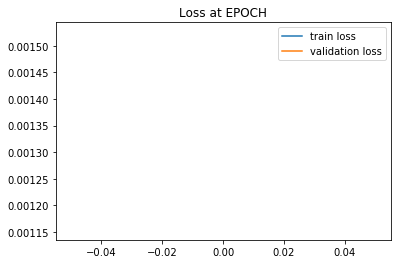

In [30]:
plt.plot(train_losses,label='train loss')
plt.plot(test_losses,label='validation loss')
plt.title('Loss at EPOCH')
plt.legend()

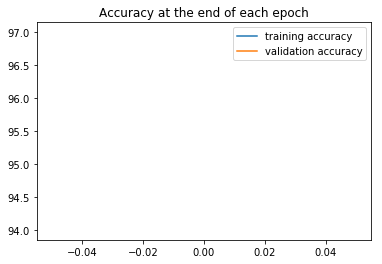

In [31]:
plt.plot([t/600 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [32]:
# Extract the data all at once, not in batches
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

In [33]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)  # we don't flatten the data this time
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')

Test accuracy: 9780/10000 =  97.800%


In [34]:
# print a row of values for reference
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))
print(np.arange(10).reshape(1,10))
print()

# print the confusion matrix
print(confusion_matrix(predicted.view(-1), y_test.view(-1)))

[[   0    1    2    3    4    5    6    7    8    9]]

[[ 965    0    3    0    0    1    3    0    5    2]
 [   0 1129    4    0    0    0    2    4    0    0]
 [   1    1  984    4    0    0    0    2    0    0]
 [   0    2    1  978    0    5    0    2    1    1]
 [   1    0    2    0  976    0    7    1    2   11]
 [   0    0    0   14    0  876    5    0    0    4]
 [   6    0    1    0    1    2  938    0    1    0]
 [   1    1   13    3    0    1    0  998    1    2]
 [   2    1   24    6    0    6    3    7  963   16]
 [   4    1    0    5    5    1    0   14    1  973]]


In [35]:
    test_data[2019][0].reshape(28,28)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

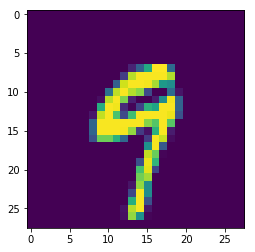

In [36]:
plt.imshow(test_data[2019][0].reshape(28,28))

In [37]:
model.eval()
with torch.no_grad():
   new_prediction = model(test_data[2019][0].view(1,1,28,28)) 

In [38]:
new_prediction.argmax()

tensor(9)

In [39]:
    test_data[444][0].reshape(28,28)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

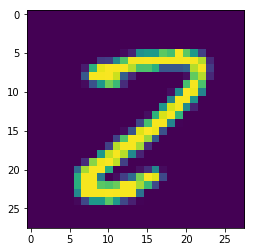

In [40]:
plt.imshow(test_data[444][0].reshape(28,28))

In [41]:
model.eval()
with torch.no_grad():
   new_prediction = model(test_data[444][0].view(1,1,28,28)) 

In [42]:
new_prediction.argmax()

tensor(8)

In [ ]:
torch.save(model.state_dict(),'Models/myMNISTCNNModel.pt')